In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
import matplotlib.colors as clr


import pandas as pd
from io import StringIO 
from astropy.io import ascii
import math
import random
from scipy.interpolate import griddata

import matplotlib.lines as mlines
import scipy
from scipy.stats import kde
from scipy.ndimage import gaussian_filter
from matplotlib.path import Path
import os

import matplotlib.image as mpimg
from astropy.wcs import WCS
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit

from shapely.geometry import Polygon
import fitsio
from fitsio import FITS,FITSHDR

from gala.coordinates import MagellanicStreamNidever08
import gala.coordinates as gc
import astropy.coordinates as coord


from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

### load molecular cloud data from Wong 2011. Use table5: "physical decompositon" (this is the table Krista used)

In [5]:
df = pd.read_csv('/Users/amymiller/sync_bm/research/vmc2/datafiles/wong/table5.txt', delimiter= '\s+', index_col=False)


In [6]:
#create molecular cloud dictionary
mcs={}
mcs['ra']=df['ra'].values
mcs['dec']=df['dec'].values

#convert major and minor axis from pc to degress. At distance of LMC 1 deg ~ 870 pc
mcs['maj']=np.array([i/871 for i in df['maj'].values])
mcs['min']=np.array([i/871 for i in df['min'].values])
mcs['pa']=np.array([float(i) for i in df['PA'].values])
mcs['r']=np.array([i/871 for i in df['r'].values])

### load VMC tile deep stack LMC 6_6

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2010-11-10T08:04:24.776' from MJD-END'. [astropy.wcs.wcs]


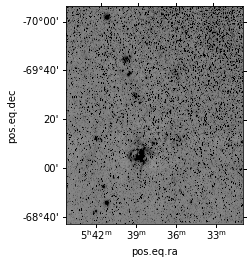

In [8]:

filename = get_pkg_data_filename('/Users/amymiller/sync_bm/research/vmc2/datafiles/e20191014_00130000215_dp_st_tl.fit')

hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)

#plt.figure(figsize=(10,10))
plt.figure()
ax=plt.subplot(projection=wcs)

ax.imshow(hdu.data,vmin=6450,vmax=6550,cmap='gray_r',origin='lower')


In [9]:
xmin,xmax,ymin,ymax = 12793,0,15683,0

In [10]:
def rotated_ellipse(x0,y0,a,b,pa,ff):
    
    #major axis is parallel to y axis
    #a is major radius in deg
    #b is minor radius in deg
    #x0,y0 are equaltorial central coord
    #pa is position angle north to east
    #ff is to be multplied to a,b to increase/decrease size

    rad = np.deg2rad(pa)
    
    #xx = [(((ff*b)/np.cos(np.deg2rad(y0)))*np.sin(i))*np.cos(rad) - (((2*a*np.cos(i)))/np.cos(np.deg2rad(y0)))*np.sin(rad) + x0 for i in np.linspace(0,2*np.pi,1000)]

    xx = [((ff*b)*np.sin(i))*np.cos(rad)/np.cos(np.deg2rad(y0)) - (((ff*a)*np.cos(i)))*np.sin(rad)/np.cos(np.deg2rad(y0)) + x0 for i in np.linspace(0,2*np.pi,1000)]
    
    yy = [((ff*b)*np.sin(i))*np.sin(rad) + ((ff*a)*np.cos(i))*np.cos(rad) + y0 for i in np.linspace(0,2*np.pi,1000)]
    
    
    return xx,yy

In [11]:
def circle(rr,x0,y0):
    
    xx = [rr*np.cos(i)/np.cos(np.deg2rad(y0)) + x0 for i in np.linspace(0,2*np.pi,1000)]
    
    yy = [rr*np.sin(i) + y0 for i in np.linspace(0,2*np.pi,1000)]
    
    return xx,yy

1 deg ~ 871 pc

make line in dec.



In [12]:
length = 100/871

In [13]:
top = -69.5
bottom = top-length

In [14]:
yarray = np.linspace(top,bottom,100)

In [15]:
xarray = np.ones(len(yarray))*83.3

In [16]:
pointx = 83.28

In [17]:
pointy = top

"ax3.xaxis.set_minor_locator(AutoMinorLocator())\nax3.yaxis.set_minor_locator(AutoMinorLocator())\nax3.tick_params(axis='both', which='major',labelsize=15)\nax3.set_xlabel('pos.eq.ra',fontsize=10)\nax3.set_ylabel('',fontsize=10)"

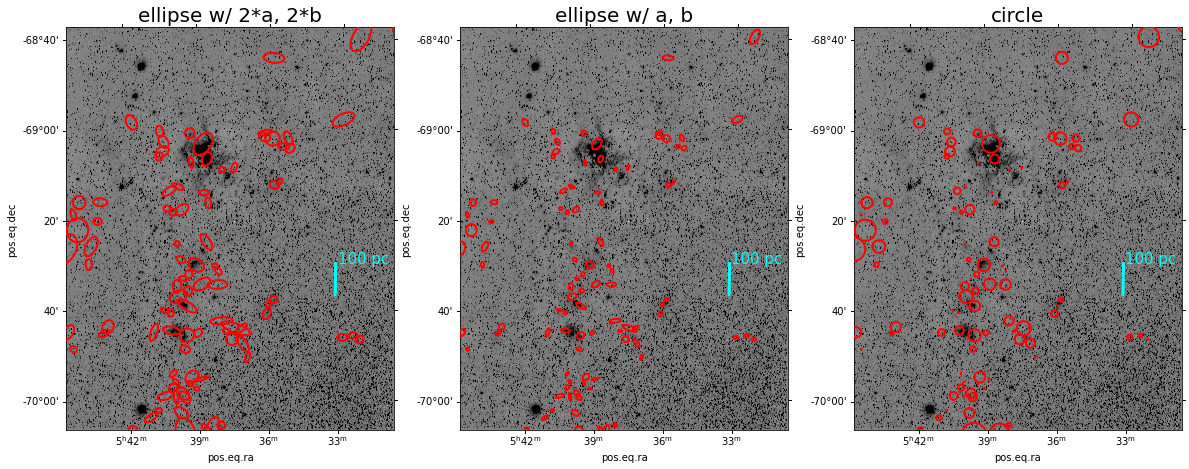

In [27]:
plt.figure(figsize=(20,8))
#plt.figure()
ax1=plt.subplot(131,projection=wcs)

ax1.imshow(hdu.data,vmin=6450,vmax=6550,cmap='gray_r',origin='lower')
ax1.set(xlim=(xmax, xmin), ylim=(ymin, ymax))

xxx,yyy = rotated_ellipse(mcs['ra'],mcs['dec'],mcs['maj'],mcs['min'],-mcs['pa'],2) 
pix_xxx,pix_yyy = wcs.all_world2pix(xxx,yyy,1)
ax1.plot(pix_xxx,pix_yyy,c='r',lw=2)
ax1.set_title('ellipse w/ 2*a, 2*b',fontsize=20)

pix_xxx,pix_yyy = wcs.all_world2pix(xarray,yarray,1)
ax1.plot(pix_xxx,pix_yyy,c='cyan',lw=3)

pix_xxx,pix_yyy = wcs.all_world2pix(pointx,pointy,1)
ax1.annotate('100 pc',(pix_xxx,pix_yyy),c='cyan',size=15)

'''ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(axis='both', which='major',labelsize=15)
ax1.set_xlabel('pos.eq.ra',fontsize=10)
ax1.set_ylabel('',fontsize=10)'''

ax2=plt.subplot(132,projection=wcs)
ax2.imshow(hdu.data,vmin=6450,vmax=6550,cmap='gray_r',origin='lower')
ax2.set(xlim=(xmax, xmin), ylim=(ymin, ymax))

xxx,yyy = rotated_ellipse(mcs['ra'],mcs['dec'],mcs['maj'],mcs['min'],-mcs['pa'],1) 
pix_xxx,pix_yyy = wcs.all_world2pix(xxx,yyy,1)
ax2.plot(pix_xxx,pix_yyy,c='r',lw=2)
ax2.set_title('ellipse w/ a, b',fontsize=20)

pix_xxx,pix_yyy = wcs.all_world2pix(xarray,yarray,1)
ax2.plot(pix_xxx,pix_yyy,c='cyan',lw=3)

pix_xxx,pix_yyy = wcs.all_world2pix(pointx,pointy,1)
ax2.annotate('100 pc',(pix_xxx,pix_yyy),c='cyan',size=15)
'''ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(axis='both', which='major',labelsize=15)
ax2.set_xlabel('pos.eq.ra',fontsize=10)
ax2.set_ylabel('',fontsize=10)'''

ax3=plt.subplot(133,projection=wcs)

ax3.imshow(hdu.data,vmin=6450,vmax=6550,cmap='gray_r',origin='lower')
ax3.set(xlim=(xmax, xmin), ylim=(ymin, ymax))

xxx,yyy = circle(mcs['r'],mcs['ra'],mcs['dec']) 
pix_xxx,pix_yyy = wcs.all_world2pix(xxx,yyy,1)
ax3.plot(pix_xxx,pix_yyy,c='r',lw=2)
ax3.set_title('circle',fontsize=20)

pix_xxx,pix_yyy = wcs.all_world2pix(xarray,yarray,1)
ax3.plot(pix_xxx,pix_yyy,c='cyan',lw=3)

pix_xxx,pix_yyy = wcs.all_world2pix(pointx,pointy,1)
ax3.annotate('100 pc',(pix_xxx,pix_yyy),c='cyan',size=15)

'''ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(axis='both', which='major',labelsize=15)
ax3.set_xlabel('pos.eq.ra',fontsize=10)
ax3.set_ylabel('',fontsize=10)'''

 

Text(0.5, 1.0, 'comparing major axis, minor axis, radius from table')

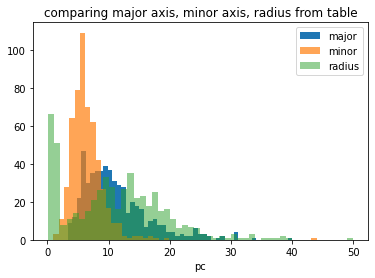

In [28]:
plt.figure()
plt.hist(df['maj'].values,bins=50,label='major')
plt.hist(df['min'].values,bins=50,alpha=0.7,label='minor')
plt.hist(df['r'].values,bins=50,alpha=0.5,label='radius')
plt.legend()
plt.xlabel('pc')
plt.title('comparing major axis, minor axis, radius from table')

Text(0.5, 1.0, 'comparing major axis, minor axis, radius from table')

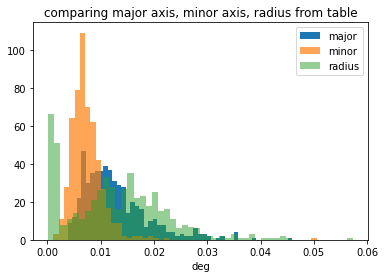

In [30]:
plt.figure()
plt.hist(mcs['maj'],bins=50,label='major')
plt.hist(mcs['min'],bins=50,alpha=0.7,label='minor')
plt.hist(mcs['r'],bins=50,alpha=0.5,label='radius')
plt.legend()
plt.xlabel('deg')
plt.title('comparing major axis, minor axis, radius from table')

Text(0.5, 1.0, 'comparing major axis, minor axis, radius from table')

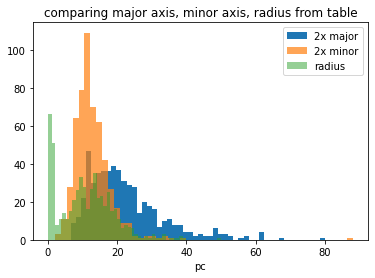

In [31]:
plt.figure()
plt.hist(2*df['maj'].values,bins=50,label='2x major')
plt.hist(2*df['min'].values,bins=50,alpha=0.7,label='2x minor')
plt.hist(df['r'].values,bins=50,alpha=0.5,label='radius')
plt.legend()
plt.xlabel('pc')
plt.title('comparing major axis, minor axis, radius from table')

area of circle, ellipse, annotate

ca = pi*r**2

ea = pi*a*b

In [33]:
mcs['c_area_pc'] = [np.pi*(r**2) for r in df['r'].values]

In [34]:
mcs['e_area_pc'] = []

for index in range(0,len(df['maj'].values)):
    
    mcs['e_area_pc'].append(np.pi*df['maj'].values[index]*df['min'].values[index])

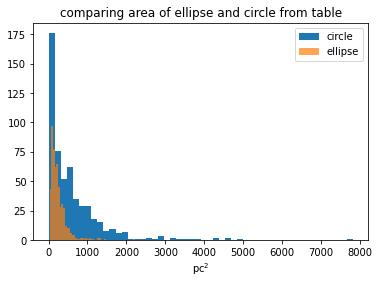

In [35]:
plt.figure()
plt.hist(mcs['c_area_pc'],bins=50,label='circle')
plt.hist(mcs['e_area_pc'],bins=50,alpha=0.7,label='ellipse')
plt.xlabel('pc$^2$')
plt.title('comparing area of ellipse and circle from table')
plt.legend()

In [37]:
mcs['c_area_deg'] = [np.pi*(r**2) for r in mcs['r']]

In [40]:
mcs['e_area_deg'] = []

for index in range(0,len(mcs['maj'])):
    
    mcs['e_area_deg'].append(np.pi*mcs['maj'][index]*mcs['min'][index])

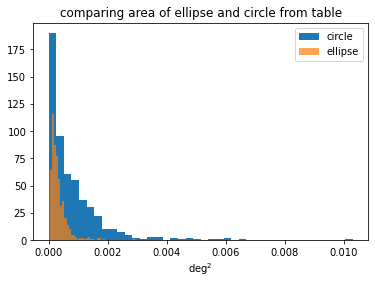

In [42]:
plt.figure()
plt.hist(mcs['c_area_deg'],bins=40,label='circle')
plt.hist(mcs['e_area_deg'],bins=40,alpha=0.7,label='ellipse')
plt.xlabel('deg$^2$')
plt.title('comparing area of ellipse and circle from table')
plt.legend()

In [45]:
mcs['e_area_pc2'] = []

for index in range(0,len(mcs['maj'])):
    
    mcs['e_area_pc2'].append(4*np.pi*df['maj'].values[index]*df['min'].values[index])

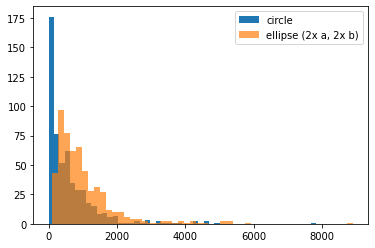

In [48]:
plt.figure()
plt.hist(mcs['c_area_pc'],bins=50,label='circle')
plt.hist(mcs['e_area_pc2'],bins=50,alpha=0.7,label='ellipse (2x a, 2x b)')

plt.legend()